In [ ]:
import pandas as pd
import pyodbc
import numpy as np
import plotly.express as px
from datetime import datetime
import statsmodels.api as sm

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 30

def file_to_string(fileName):
    file = open(fileName,'r')
    string = file.read()
    file.close()
    return string.replace('$DATE$','2023-08-28')

def timestamp():
    return datetime.now().strftime('%Y-%m-%d %I:%M:%S %p')

def run_query(query):
    print("Query Start " + timestamp())
    cnxn = pyodbc.connect('DSN=edp-workbench-cshub', autocommit=True)
    df = pd.read_sql_query(query,cnxn)
    cnxn.close()
    print("Query End " + timestamp())
    return df
    
def add_conditionals(df):
    df = df.copy()
    df['Date']=pd.to_datetime(df['Date'])
    
    df['1st Reactive ExAsst Group'] = (df['Employee'].isin((
        581139, 569375, 575996, 547655, 573190, 573276,
        572909, 573192, 573585, 573573, 572815, 552121,
        576911, 572247, 364717, 426097, 554487, 575731,
        576565, 577073, 577246, 579162, 580895, 580911,
        581015, 581145, 581275
        ))).astype(int)
    
    df['2nd Reactive ExAsst Group'] = (df['Employee'].isin((
        548026, 548646, 579630, 550446, 569153, 578299
    ))).astype(int)

    df['Proactive ExAsst Group'] = (df['Employee'].isin((
        573190, 573276, 572909, 573192, 573585,
        573573, 572815, 552121, 576911, 572247
        ))).astype(int)

    df['After Reactive  ExAsst Launch']=(df['Date']>=datetime(2023,9,25)).astype(int)
    df['After Proactive ExAsst Launch']=(df['Date']>=datetime(2023,11,10)).astype(int)

    df['Has Proactive'] = df['Proactive ExAsst Group'] * df['After Proactive ExAsst Launch']
    
    df['Has Reactive'] = np.sign((
        df['After Reactive  ExAsst Launch'] * df['1st Reactive ExAsst Group']
        +
        df['After Proactive ExAsst Launch'] * df['2nd Reactive ExAsst Group']
        ))

    df['Test Group For This Period'] = np.select(condlist = [df['Has Proactive']==1,df['Has Reactive']==1], choicelist = ['Proactive','Reactive'],default='Control')
    df['Test Group After Launch'] = np.select(
        condlist = [
            df['Proactive ExAsst Group']==1,
            np.logical_and(
                np.logical_or(df['1st Reactive ExAsst Group']==1,df['2nd Reactive ExAsst Group']==1)
                ,df['Proactive ExAsst Group']==0)
            ],
        choicelist = ['Proactive','Reactive'],default='Control')

    df['Day'] = df['Date'].dt.weekday
    days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    for day in days:
        df[days[day]]=(df['Day']==day).astype(int)
    df['Week']=df['Date'].dt.isocalendar().week
    df['Weeks Ago'] = df['Week'].astype(int).max() - df['Week'].astype(int)
    for week in df['Week'].unique():
        df['Week '+str(week)]= (df['Week']==week).astype(int)
    # for queue in df['TaskQueue'].unique():
    #     df[queue] = (df['TaskQueue']==queue).astype(int)
    df['Constant'] =1
    return df

def add_metrics(df):
    df = df.copy()
    df['AHT'] = df['Total_Resolution_Time']/df['Sessions']
    df['HERO'] = df['HERO_XR_Score']/df['HERO_XR_Count']
    df['SP100'] = 100*df['Total_Accepted']/df['Total_Eligible']
    df['Transfers'] = df['Transfer_Count']/df['Transfer_Score']
    df['Constant'] =1
    return df

Index(['ExtraData_totalTime', '_header_client', 'Identities_callSid',
       'MetaData_RequestContext_Host', 'MetaData_RequestContext_User-Agent',
       'ExtraData_openAITime', 'Name', '_header_eventContext_producer',
       'ExtraData_isLive', '_header_category', '_header_eventId',
       'MetaData_RequestContext_Accept', '_header_domain', '_header_schema',
       'EventId', '_header_object', 'ExtraData_agentId',
       '_header_eventContext_category',
       'MetaData_RequestContext_Accept-Encoding', 'ExtraData_botResponse',
       '_header_eventContext_sourceType', 'ExtraData_inputMessage',
       'ExtraData_helixTime', '_header_eventContext_region',
       '_header_eventContext_ingestionTimestamp', 'ExtraData_intentTime',
       '_header_eventContext_endpoint', 'ExtraData_promptTranscript',
       '_header_source', 'MetaData_RequestContext_X-Forwarded-For',
       'ExtraData_ozmoTime', 'ExtraData_Time', 'MetaData_ServerTime',
       'MetaData_Client', 'MetaData_RequestContext_X-Forwarded-Proto',
       'ExtraData_endRequestTime', 'Time', '_header_tags', '_header_timestamp',
       'ExtraData_truncatePromptTime', 'ExtraData_transcriptsTime',
       'MetaData__eventType', 'MetaData_RequestContext_X-Amzn-Trace-Id',
       'MetaData_ProcessorType', 'ExtraData_messageType', 'ExtraData_version',
       'ExtraData_totalTokens', 'MetaData_IsTest', 'Identities_messageSid',
       'ExtraData_embeddingsTime', 'ExtraData_startRequestTime',
       'ExtraData_rerankerTime', 'ExtraData_helixNewTime', '_header_action',
       'MetaData_RequestContext_Content-Type', 'Scope', 'FullName',
       'MetaData_RequestContext_X-Forwarded-Port',
       '_header_eventContext_correlationId', 'Identities_SessionId',
       'ExtraData_deviceDetectionTime'],

In [13]:
run_query(    """SELECT
        element_at(VHE.edp_raw_data_map, 'Identities_callSid')
    FROM 
        hive.care.l1_verizon_home_events VHE
        
    WHERE 1=1
        AND element_at(VHE.edp_raw_data_map, '_header_eventContext_producer') = 'eip-ingestion-data-science'
        AND element_at(VHE.edp_raw_data_map, 'Identities_messageSid') IS NOT NULL
        AND element_at(VHE.edp_raw_data_map, 'Name') = 'RequestSummaryVoice'
        AND element_at(VHE.edp_raw_data_map, 'Scope')='GenerativeAISearchBotVoice'
        AND DATE(edp_updated_date) = DATE '2023-12-07'""")

Query Start 2023-12-08 09:20:07 AM


C:\Users\austen.moore\AppData\Local\Temp\ipykernel_9280\2524902359.py:24: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Query End 2023-12-08 09:20:11 AM


,_col0
0,No_CallSid
1,No_CallSid
2,No_CallSid
3,No_CallSid
4,No_CallSid
...,...
2958,No_CallSid
2959,CA90679a580acd1b687786e4848f582995
2960,No_CallSid
2961,CA3fece76630cb3f209a509c8aa477f8d4


In [ ]:
df_daily = run_query(file_to_string('DailyMetrics.SQL'))
df_daily.head()
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

In [14]:
metric = {'SP100':['Total_Accepted','Total_Eligible']}
metric

weekly_summary = df_daily.copy()
weekly_summary = add_conditionals(weekly_summary)
weekly_summary['Week'] = weekly_summary['Date'].dt.isocalendar().week
weekly_summary['SP100']=100*weekly_summary['Total_Accepted']/weekly_summary['Total_Eligible']
weekly_summary['After Proactive ExAsst Launch']=weekly_summary['After Proactive ExAsst Launch'].astype(bool)
px.box(weekly_summary,y='SP100',color='After Proactive ExAsst Launch')

# weekly_summary = pd.pivot_table(weekly_summary,index='Date',aggfunc=sum,columns='Test Group After Launch',values=['Total_Accepted','Total_Eligible'])
# weekly_summary=weekly_summary['Total_Accepted']/weekly_summary['Total_Eligible']
# weekly_summary = weekly_summary*100
# # weekly_summary['Proactive Average'] = weekly_summary['Proactive'].mean()
# px.line(weekly_summary,title='SP100').update_layout(yaxis_title="SP100")


In [19]:
metricList = ['Total_Resolution_Time']
metric_Inputs = ['Sessions','Total_Resolution_Time''HERO_XR_Score','HERO_XR_Count', 'Transfer_Score', 'Transfer_Count',
              'Helix_Searches', 'Helix_Sessions' 'Total_Eligible','Total_Accepted']
test_df = add_conditionals(df_daily)
test_df = add_metrics(test_df)
px.histogram(test_df['Total_Resolution_Time']).show()
test_df = test_df.dropna()
test_df.info(verbose=False)
display(test_df.head(5))
for metric in metricList:
    display(sm.OLS(
        endog = test_df[metric],
        exog = test_df[['Has Proactive','Proactive ExAsst Group','Offer','Weeks Ago','Constant']]
        ).fit().summary())
    # test_df = add_metrics(test_df)
    # px.box(test_df,y=metric,color='Test Group For This Period', title=metric).show()
    graph_df = pd.pivot_table(test_df.copy(),values=metric,columns='Test Group After Launch',index='Date')
    px.line(graph_df,title=metric).show()
    graph_df = pd.pivot_table(test_df.copy(),values=metric,columns='Test Group For This Period',index='Date')
    px.line(graph_df,title=metric).show()

    del graph_df
del test_df, metricList, metric_Inputs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 1524
Columns: 48 entries, Employee to Transfers
dtypes: UInt32(1), datetime64[ns](1), float64(11), int32(26), int64(7), object(2)
memory usage: 363.5+ KB


,Employee,Date,Hours_Worked,Sessions,Total_Resolution_Time,HERO_XR_Score,HERO_XR_Count,Transfer_Score,Transfer_Count,Helix_Searches,Helix_Sessions,Total_Eligible,Total_Accepted,1st Reactive ExAsst Group,2nd Reactive ExAsst Group,Proactive ExAsst Group,After Reactive ExAsst Launch,After Proactive ExAsst Launch,Has Proactive,Has Reactive,Test Group For This Period,Test Group After Launch,Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Week,Weeks Ago,Week 42,Week 48,Week 41,Week 40,Week 43,Week 46,Week 44,Week 47,Week 45,Week 39,Week 49,Constant,AHT,HERO,SP100,Transfers
0,548646,2023-10-19,8.13,16,14986,13.00,"1,100.52",16.00,0.00,0,0,6.00,1.00,0,1,0,1,0,0,0,Control,Reactive,3,0,0,0,1,0,0,0,42,7,1,0,0,0,0,0,0,0,0,0,0,1,936.62,0.01,16.67,0.00
1,573573,2023-12-01,6.95,21,16629,15.00,"1,173.87",21.00,0.00,0,0,19.00,3.00,1,0,1,1,1,1,1,Proactive,Proactive,4,0,0,0,0,1,0,0,48,1,0,1,0,0,0,0,0,0,0,0,0,1,791.86,0.01,15.79,0.00
2,581139,2023-10-17,7.78,20,19828,18.00,"1,419.51",20.00,0.00,0,0,13.00,1.00,1,0,0,1,0,0,1,Reactive,Reactive,1,0,1,0,0,0,0,0,42,7,1,0,0,0,0,0,0,0,0,0,0,1,991.40,0.01,7.69,0.00
3,572247,2023-10-11,6.90,14,12609,7.00,556.93,14.00,0.00,0,0,10.00,0.00,1,0,1,1,0,0,1,Reactive,Proactive,2,0,0,1,0,0,0,0,41,8,0,0,1,0,0,0,0,0,0,0,0,1,900.64,0.01,0.00,0.00
4,550446,2023-10-05,7.26,17,15445,15.00,"1,189.11",17.00,0.00,0,0,15.00,0.00,0,1,0,1,0,0,0,Control,Reactive,3,0,0,0,1,0,0,0,40,9,0,0,0,1,0,0,0,0,0,0,0,1,908.53,0.01,0.00,0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Total_Resolution_Time   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     8.836
Date:                   Fri, 08 Dec 2023   Prob (F-statistic):           8.45e-06
Time:                           09:28:18   Log-Likelihood:                -13022.
No. Observations:                   1306   AIC:                         2.605e+04
Df Residuals:                       1302   BIC:                         2.607e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Has Proactive          -2050.2482    605.368     -3.387      0.001   -3237.851    -862.645
Proactive ExAsst Group  1624.7749    398.934      4.073      0.000     842.151    2407.399
Weeks Ago               -220.2527     57.804     -3.810      0.000    -333.652    -106.853
Constant                1.702e+04    345.301     49.296      0.000    1.63e+04    1.77e+04
==============================================================================
Omnibus:                       10.496   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.966
Skew:                          -0.115   Prob(JB):                      0.00153
Kurtosis:                       3.430   Cond. No.                         27.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
test_df = add_conditionals(df_daily)
test_df = add_metrics(test_df)

test_df = test_df.dropna()
# display(test_df.head(5))

display(sm.OLS(
    endog = test_df['AHT'],
    exog = test_df[['Has Proactive','Weeks Ago','Constant']]
    ).fit().summary())
del test_df

In [22]:
df_sessions = run_query(file_to_string('AHT And Sales.SQL'))

Query Start 2023-12-08 09:30:11 AM


C:\Users\austen.moore\AppData\Local\Temp\ipykernel_9280\2524902359.py:24: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Query End 2023-12-08 09:30:24 AM


Index(['Date', 'Employee', 'reservation_id', 'TaskQueue', 'Handle Time',
       'Offered', 'Accepted', '1st Reactive ExAsst Group',
       '2nd Reactive ExAsst Group', 'Proactive ExAsst Group',
       'After Reactive  ExAsst Launch', 'After Proactive ExAsst Launch',
       'Has Proactive', 'Has Reactive', 'Test Group For This Period',
       'Test Group After Launch', 'Day', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'Week', 'Weeks Ago',
       'Week 40', 'Week 47', 'Week 46', 'Week 45', 'Week 48', 'Week 42',
       'Week 44', 'Week 39', 'Week 41', 'Week 43', 'Week 49', 'Constant',
       'Handle Time Log', 'VZN_MTS_Bundle_EN_2233', 'VZN_Onboarding_2628',
       'VZN_5G_UPSELL_5013', 'VZN_MTS_Bundle_SP_2234',
       'VZN_SameDay_Replac_ACT_2792', 'VZN_Onboarding_SP_2629',
       'VZN_Resolution_SP_2462'],
      dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Handle Time   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     303.6
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          9.51e-315
Time:                        09:50:12   Log-Likelihood:            -1.7296e+05
No. Observations:               20907   AIC:                         3.459e+05
Df Residuals:                   20901   BIC:                         3.460e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Constant                1062.7560     17.817     59.649      0.000    1027.834    1097.678
Has Proactive           -106.8878     27.896     -3.832      0.000    -161.566     -52.210
Proactive ExAsst Group   -27.4767     17.404     -1.579      0.114     -61.590       6.636
Offered                  286.9917     13.678     20.982      0.000     260.182     313.801
Accepted                 703.2370     26.850     26.192      0.000     650.610     755.864
Weeks Ago                -17.5468      2.359     -7.439      0.000     -22.170     -12.924
==============================================================================
Omnibus:                    11093.471   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118578.511
Skew:                           2.336   Prob(JB):                         0.00
Kurtosis:                      13.690   Cond. No.                         30.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

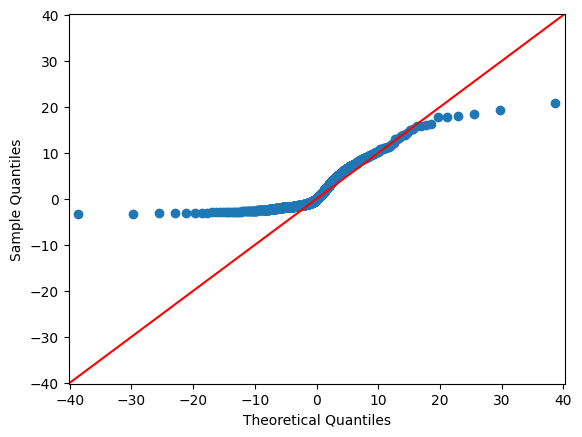

In [24]:
test_df = add_conditionals(df_sessions.copy())

# test_df = test_df[test_df['Handle Time']<=5000]
test_df['Handle Time Log'] = np.log(test_df['Handle Time'])


for queue in test_df['TaskQueue'].unique():
    test_df[queue] = (test_df['TaskQueue']==queue).astype(int)
display(test_df.columns)
X = test_df[[ 'Constant', 
            # 'Has Proactive',
            'Proactive ExAsst Group',
            'Offered', 'Accepted', 'Weeks Ago',
            # 'VZN_MTS_Bundle_EN_2233', 'VZN_Onboarding_2628'
            ]]

mdl = sm.OLS(
    endog = test_df['Handle Time'],
    exog = X
    ).fit()
display(mdl.summary())
test_df['Prediction']=mdl.predict(X)
test_df['Resid'] = test_df['Handle Time']-test_df['Prediction']

# import scipy.stats as stats
# from matplotlib import pyplot as plt
# fig = sm.qqplot(test_df['Resid'], stats.t, distargs=(7,),line='45', fit=True)
# plt.show()

px.histogram(test_df['Resid']).show()
px.scatter(test_df, x='Handle Time',y='Resid', color='Has Proactive', opacity=.2).show()
# test_df.to_excel('Dataset.xlsx')
del test_df